## Dataset: GSM4407907

## Modules installation

In [ ]:
!pip install scanpy
!pip install harmonypy
!pip install leidenalg

## Data downloading and inflation

In [ ]:
!wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4407nnn/GSM4407907/suppl/GSM4407907_barcodes.tsv.gz
!wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4407nnn/GSM4407907/suppl/GSM4407907_genes.tsv.gz
!wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4407nnn/GSM4407907/suppl/GSM4407907_matrix.mtx.gz
!wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4407nnn/GSM4407907/suppl/GSM4407907_filtered_gene_bc_matrices_h5.h5

In [ ]:
!for f in ./*.gz; do gunzip $f; done

## Set up

In [ ]:
import matplotlib as plt
import numpy as np
import pandas as pd
import scanpy as sc
import os

In [ ]:
data = sc.read_10x_h5('GSM4407907_filtered_gene_bc_matrices_h5.h5')
data

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6260 × 48816
    var: 'gene_ids'

## Quality metrics

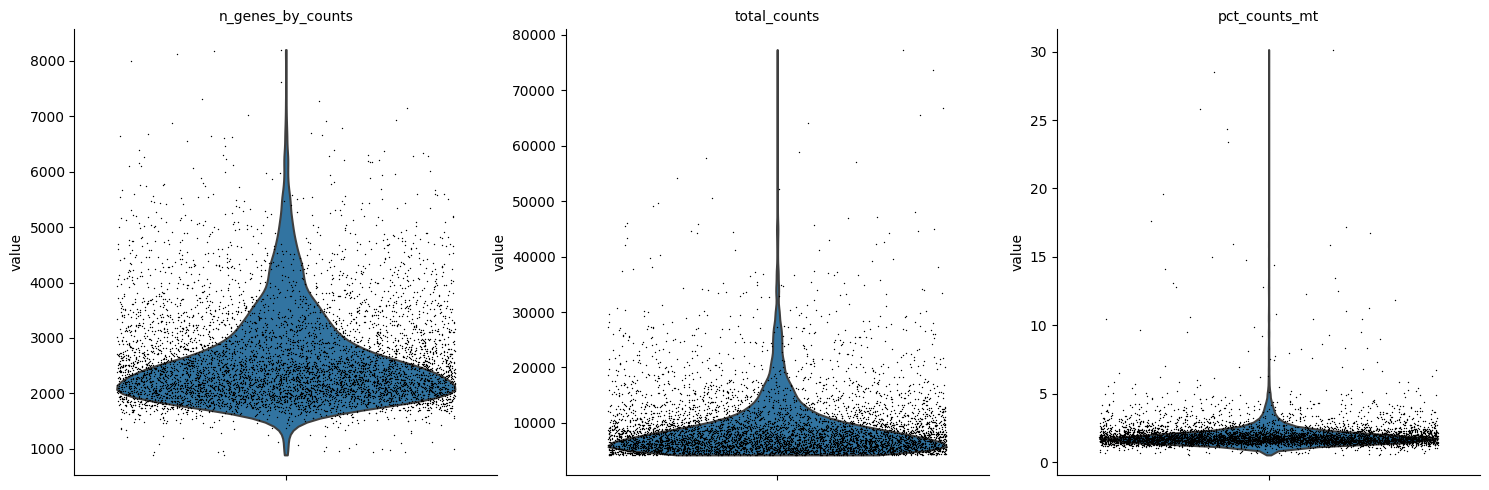

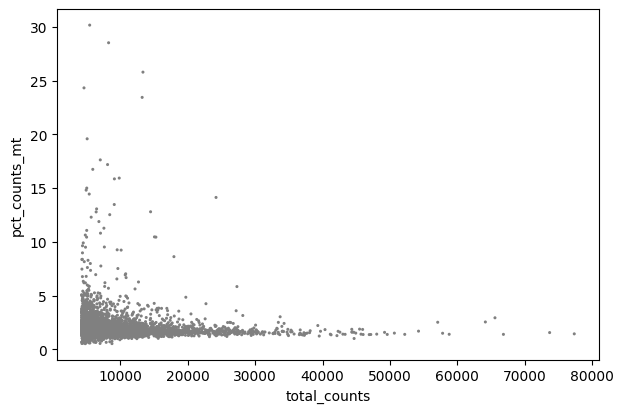

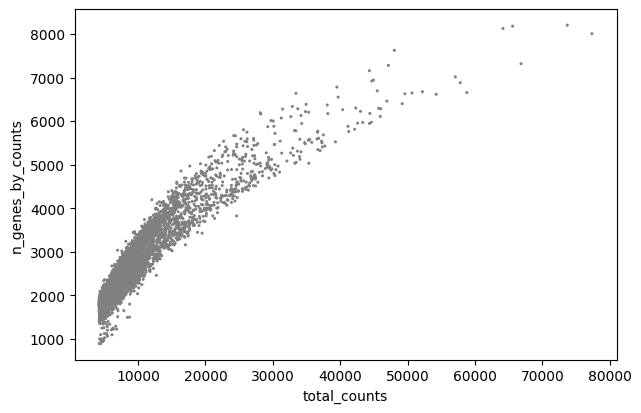

In [ ]:
data.var['mt'] = data.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(data, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

data.var_names_make_unique()
sc.pl.violin(data, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

sc.pl.scatter(data, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(data, x='total_counts', y='n_genes_by_counts')

## Filtering

In [ ]:
sc.pp.filter_cells(data, min_genes=200)
sc.pp.filter_cells(data, max_counts=25000)
sc.pp.filter_genes(data, min_cells=5)
data = data[data.obs.pct_counts_mt < 5, :]

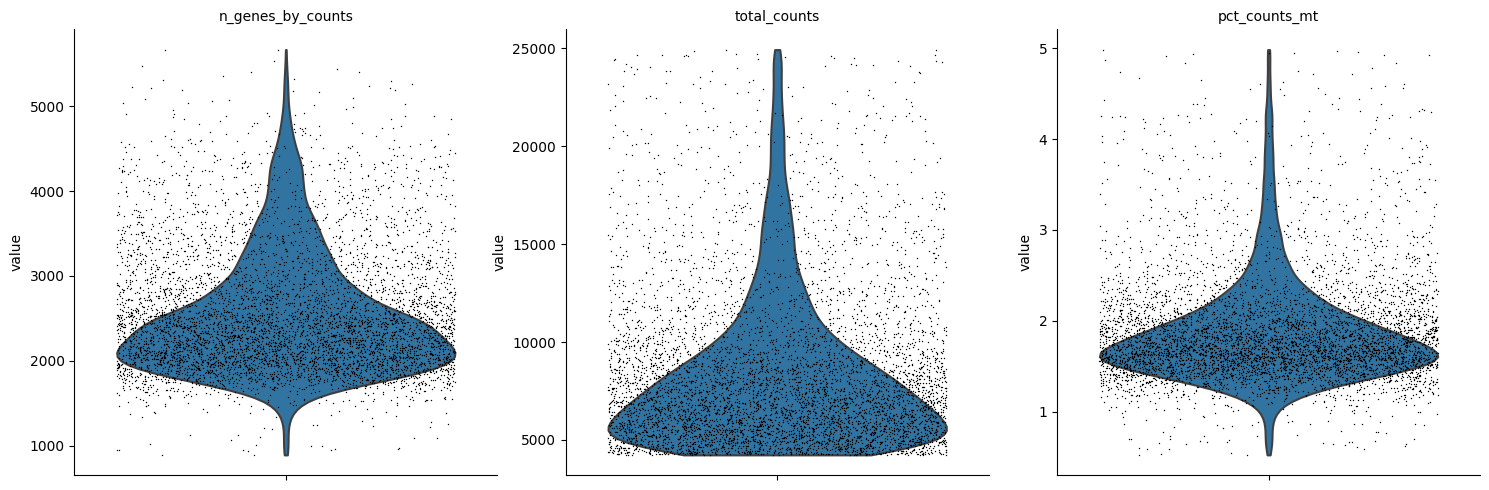

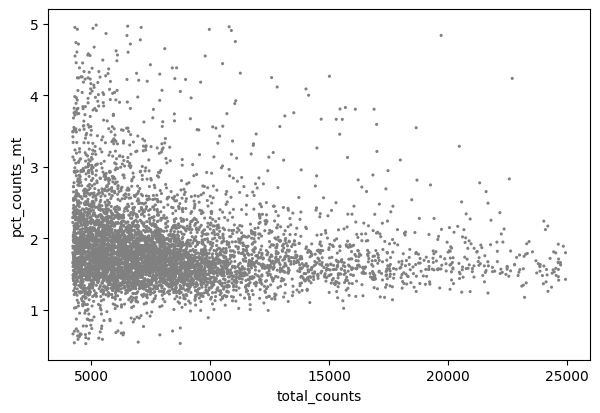

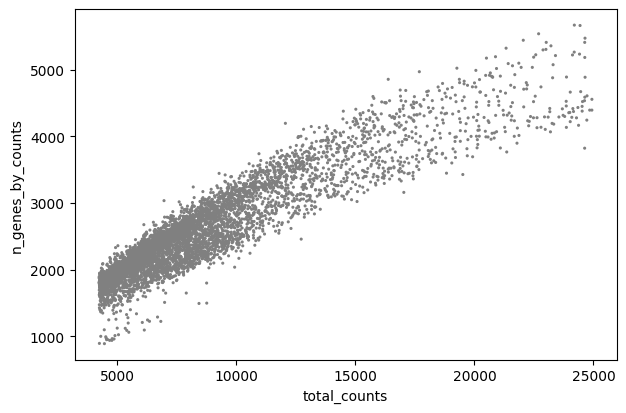

In [ ]:
sc.pl.violin(data, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
sc.pl.scatter(data, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(data, x='total_counts', y='n_genes_by_counts')

## The same plots in R

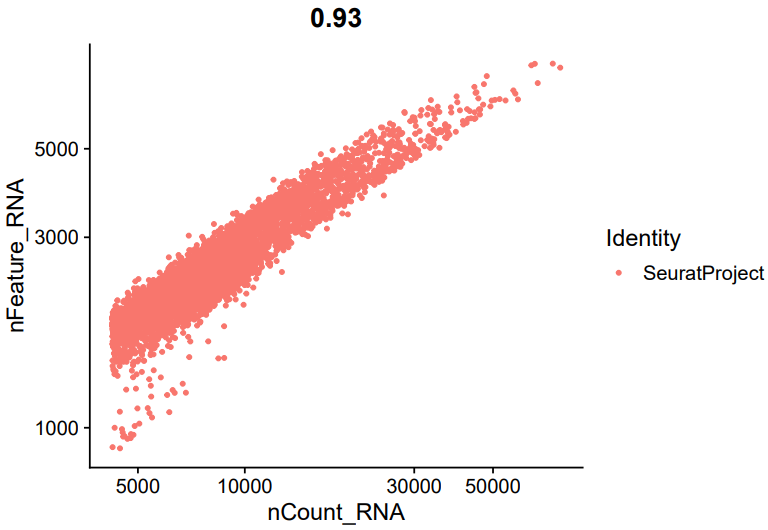

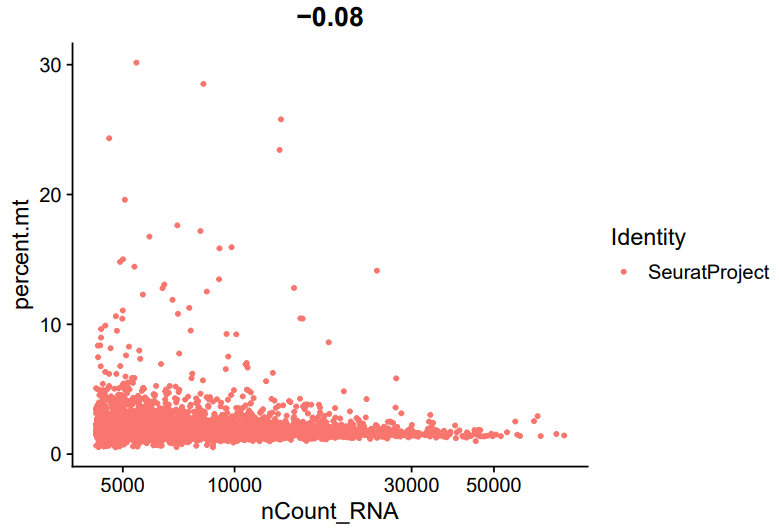

## Data normalization

In [ ]:
sc.pp.normalize_total(data, target_sum=1e4)
sc.pp.log1p(data)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Choosing HGVs

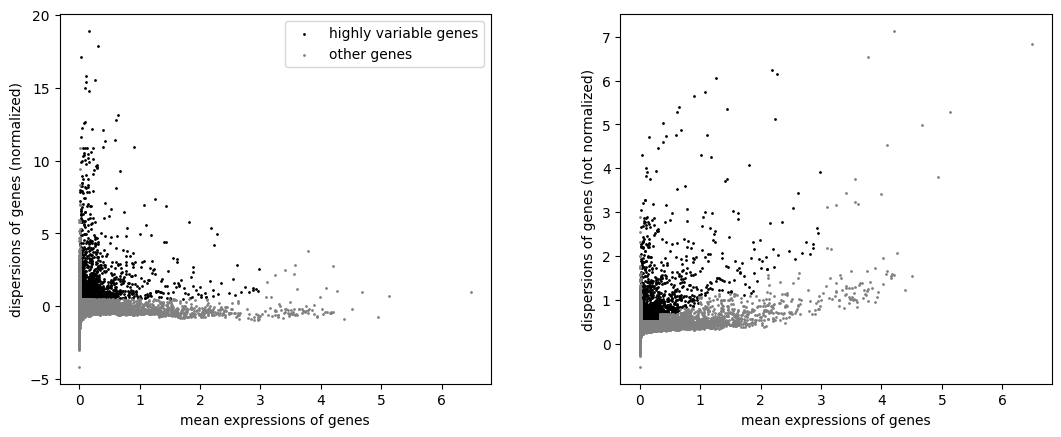

In [ ]:
sc.pp.highly_variable_genes(data, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(data)

In [ ]:
data.var.highly_variable.value_counts()

False    17926
True      1576
Name: highly_variable, dtype: int64

In [ ]:
data.raw = data
data = data[:, data.var.highly_variable]
sc.pp.scale(data, max_value=10)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## PCA

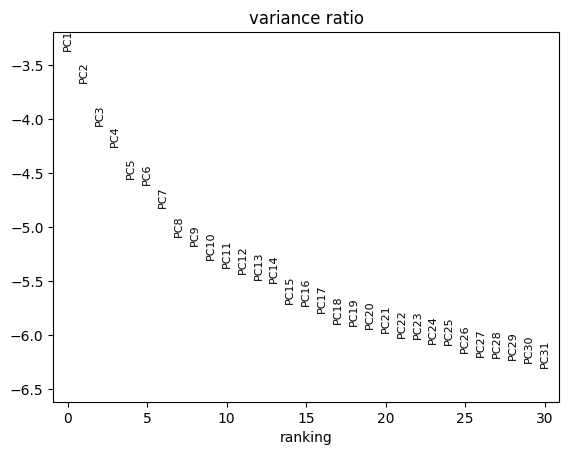

In [ ]:
sc.tl.pca(data)
sc.pl.pca_variance_ratio(data, log=True)

## The same plot in R

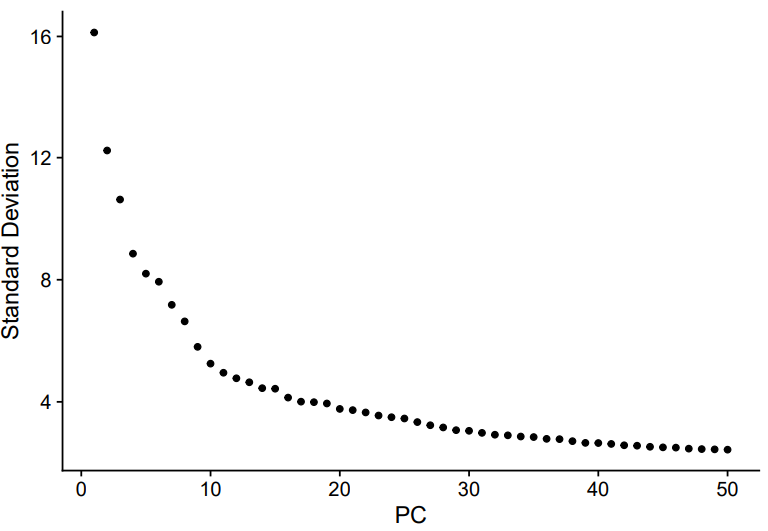

## UMAP

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


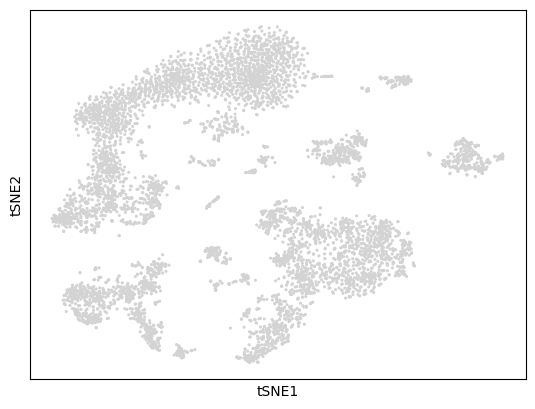

In [ ]:
sc.pp.neighbors(data, n_pcs=20, metric='cosine')
sc.tl.tsne(data)
sc.pl.tsne(data)

## Clusterization

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


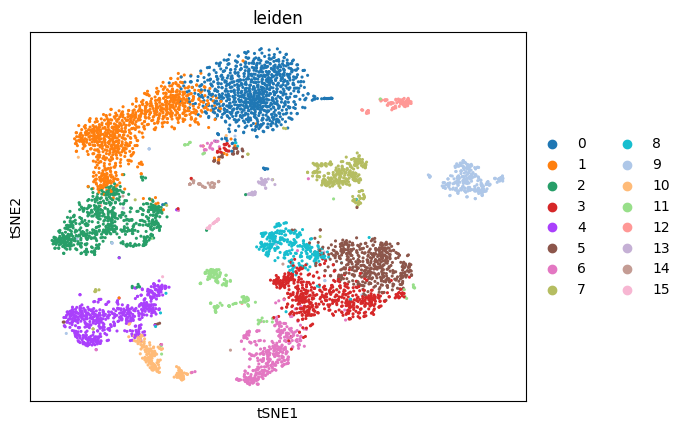

In [ ]:
sc.tl.leiden(data,  resolution=0.5)
sc.pl.tsne(data, color=['leiden'])

## The same plot in R

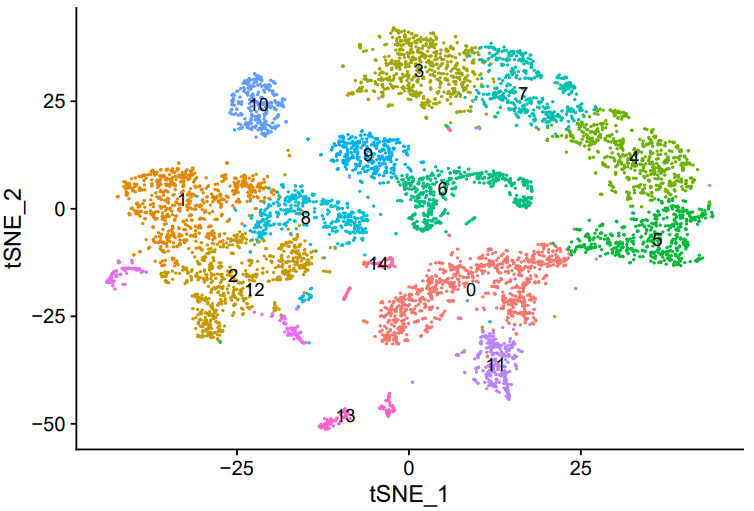

## Differential expression analysis

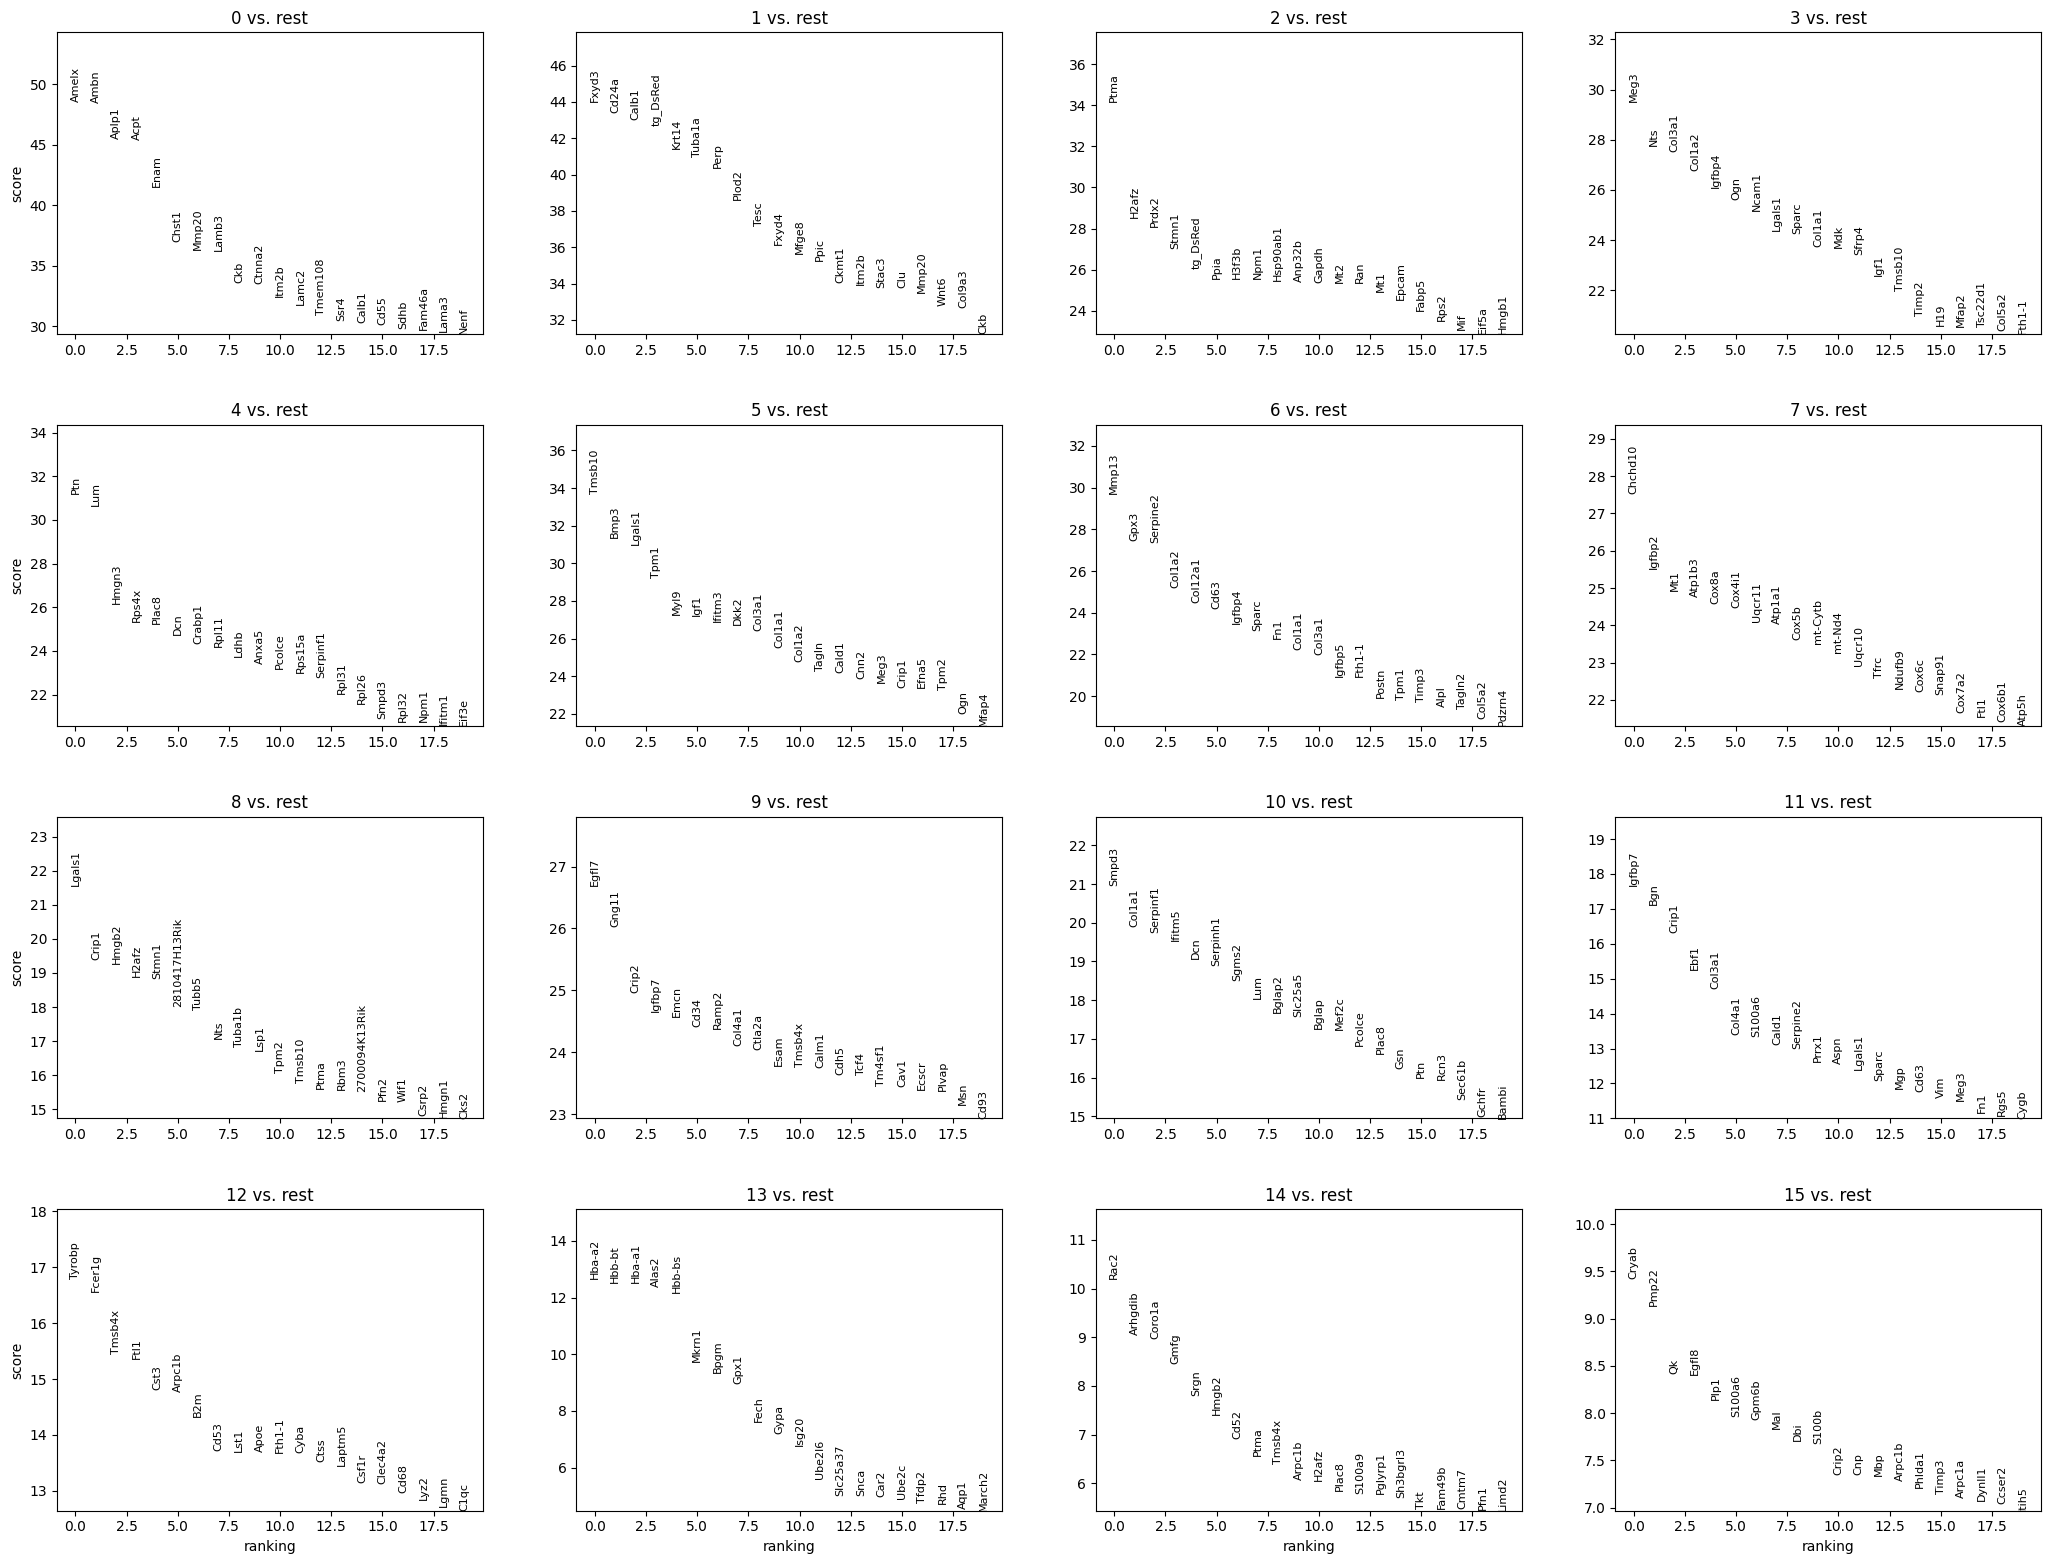

In [ ]:
sc.tl.rank_genes_groups(data, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(data, n_genes=20, sharey=False)

In [ ]:
sc.get.rank_genes_groups_df(data, group=['14']).head(n=8)

,names,scores,logfoldchanges,pvals,pvals_adj
0,Rac2,10.203040,5.406668,1.921606e-24,3.747516e-20
1,Arhgdib,9.051863,4.332111,1.405497e-19,1.370501e-15
2,Coro1a,8.955719,5.568574,3.375295e-19,2.194167e-15
3,Gmfg,8.449827,4.745396,2.917353e-17,1.422355e-13
4,Srgn,7.799438,4.907589,6.218369e-15,2.425413e-11
5,Hmgb2,7.395745,2.455147,1.406179e-13,4.570551e-10
6,Cd52,6.902439,5.027765,5.111737e-12,1.424130e-08
7,Ptma,6.556484,0.970005,5.509123e-11,1.193766e-07


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


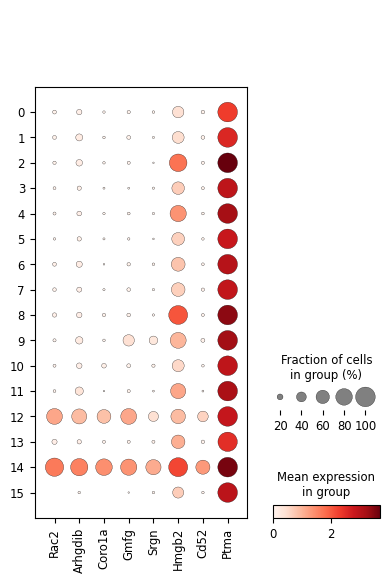

In [ ]:
marker_genes = sc.get.rank_genes_groups_df(data, group=['14']).head(n=8)['names']
sc.pl.dotplot(data, marker_genes, groupby='leiden')

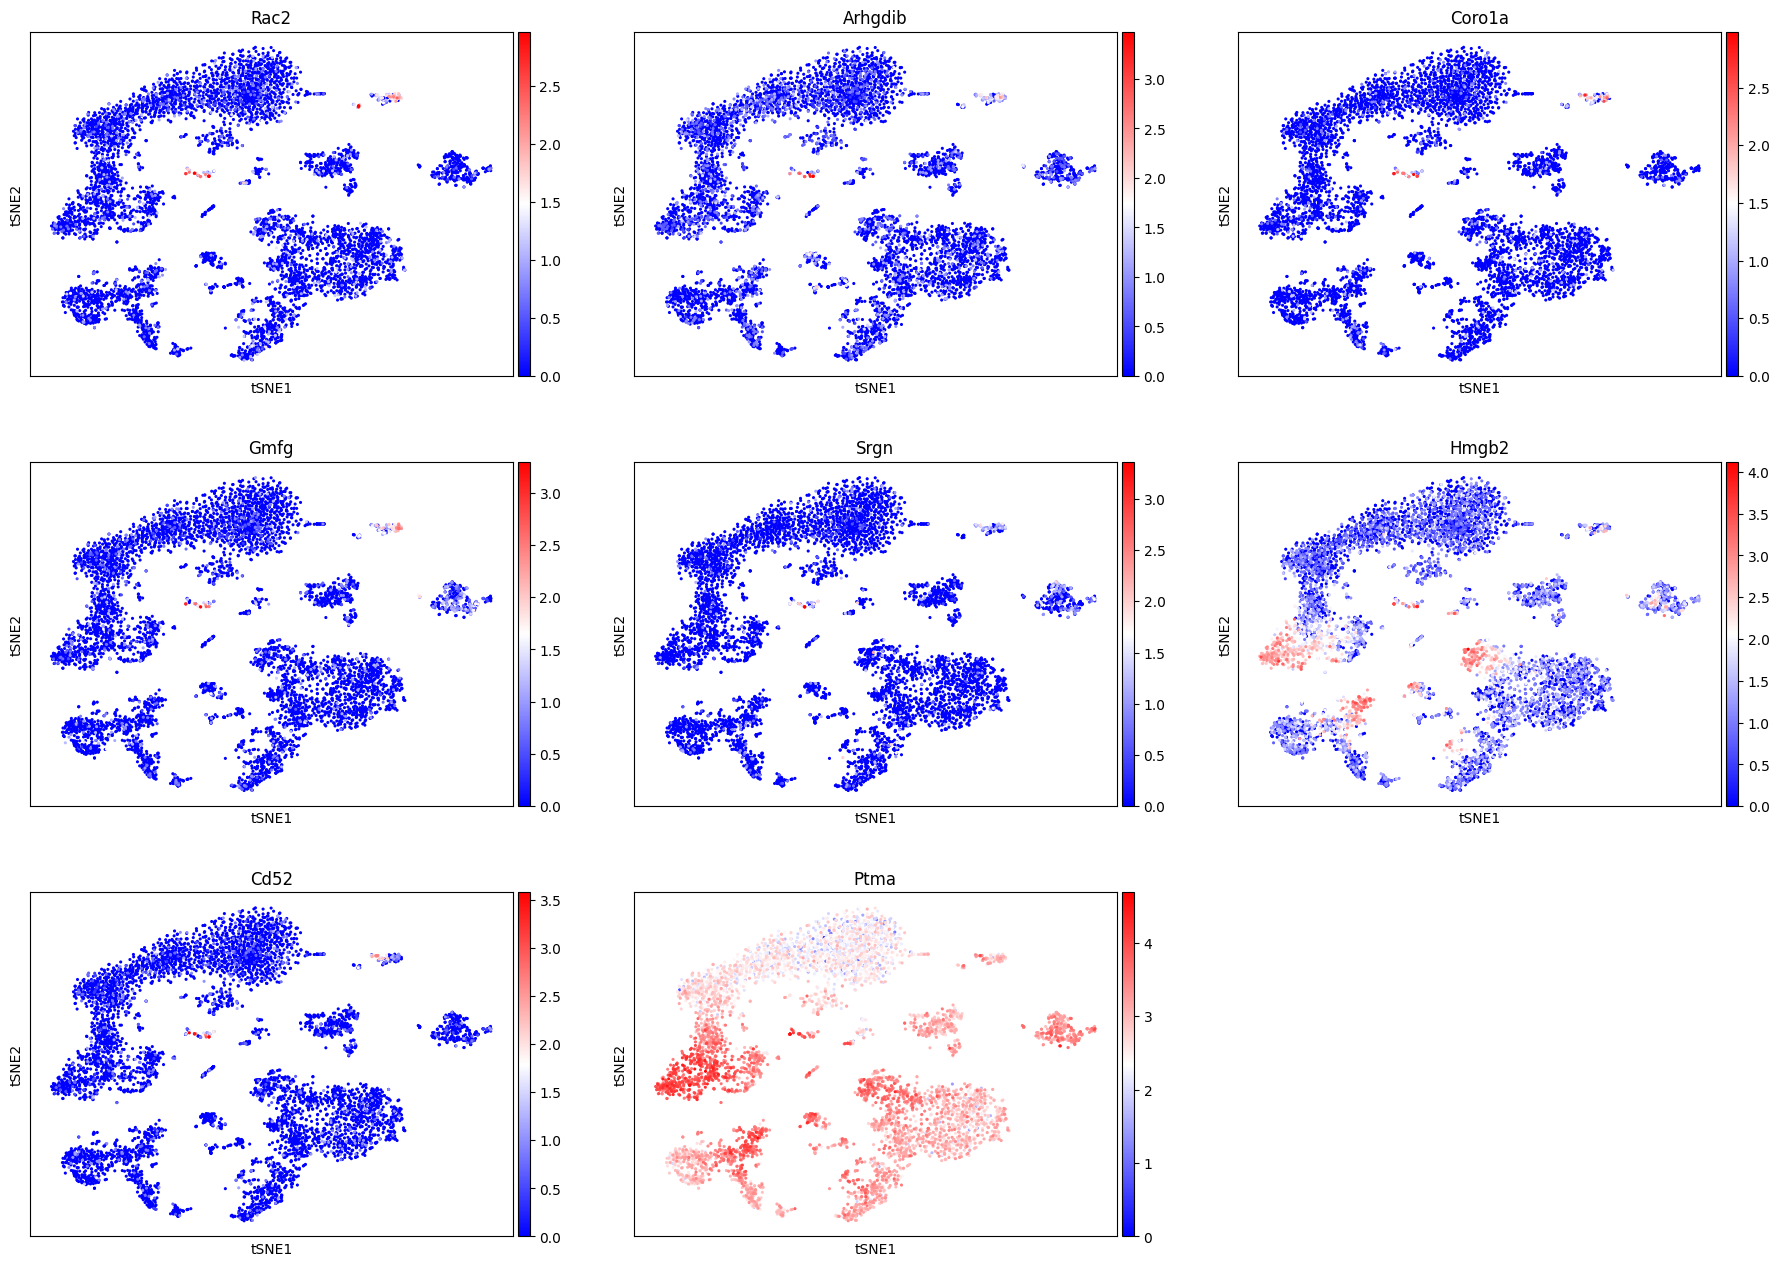

In [ ]:
sc.pl.tsne(data, color=marker_genes, color_map='bwr', ncols=3)

## Сompare with markers from the article

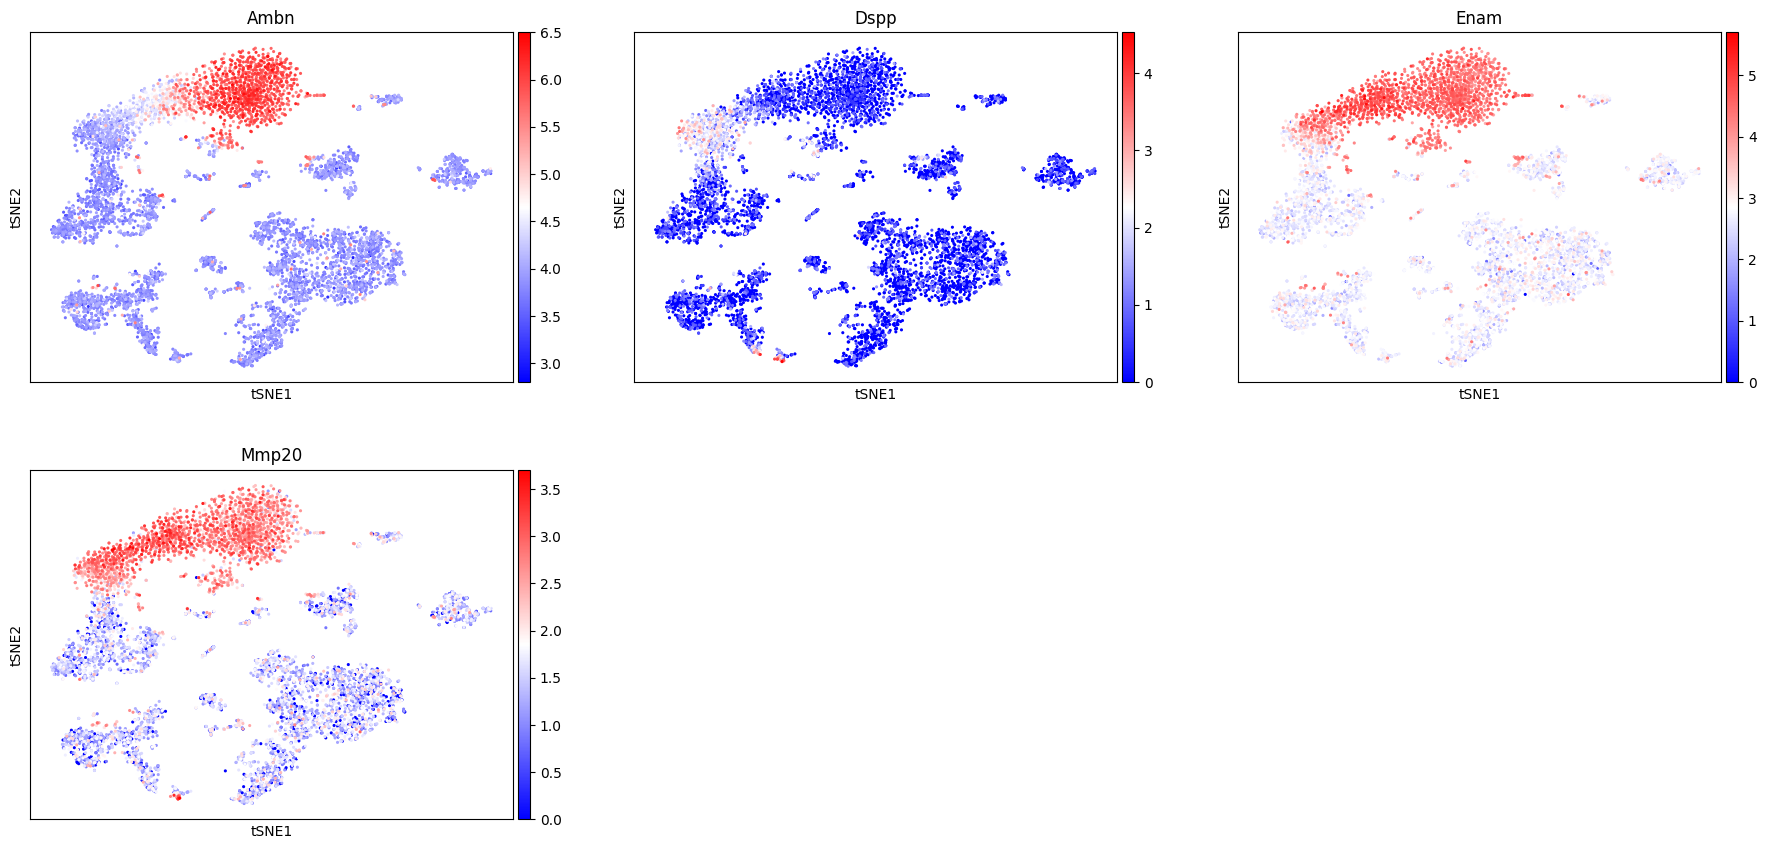

In [ ]:
sc.pl.tsne(data, color=['Ambn', 'Dspp', 'Enam', 'Mmp20'], color_map='bwr', ncols=3)

### Plots show us that markers from artice are also highly expressed in specific type of cells. The clusters are definite and solid.

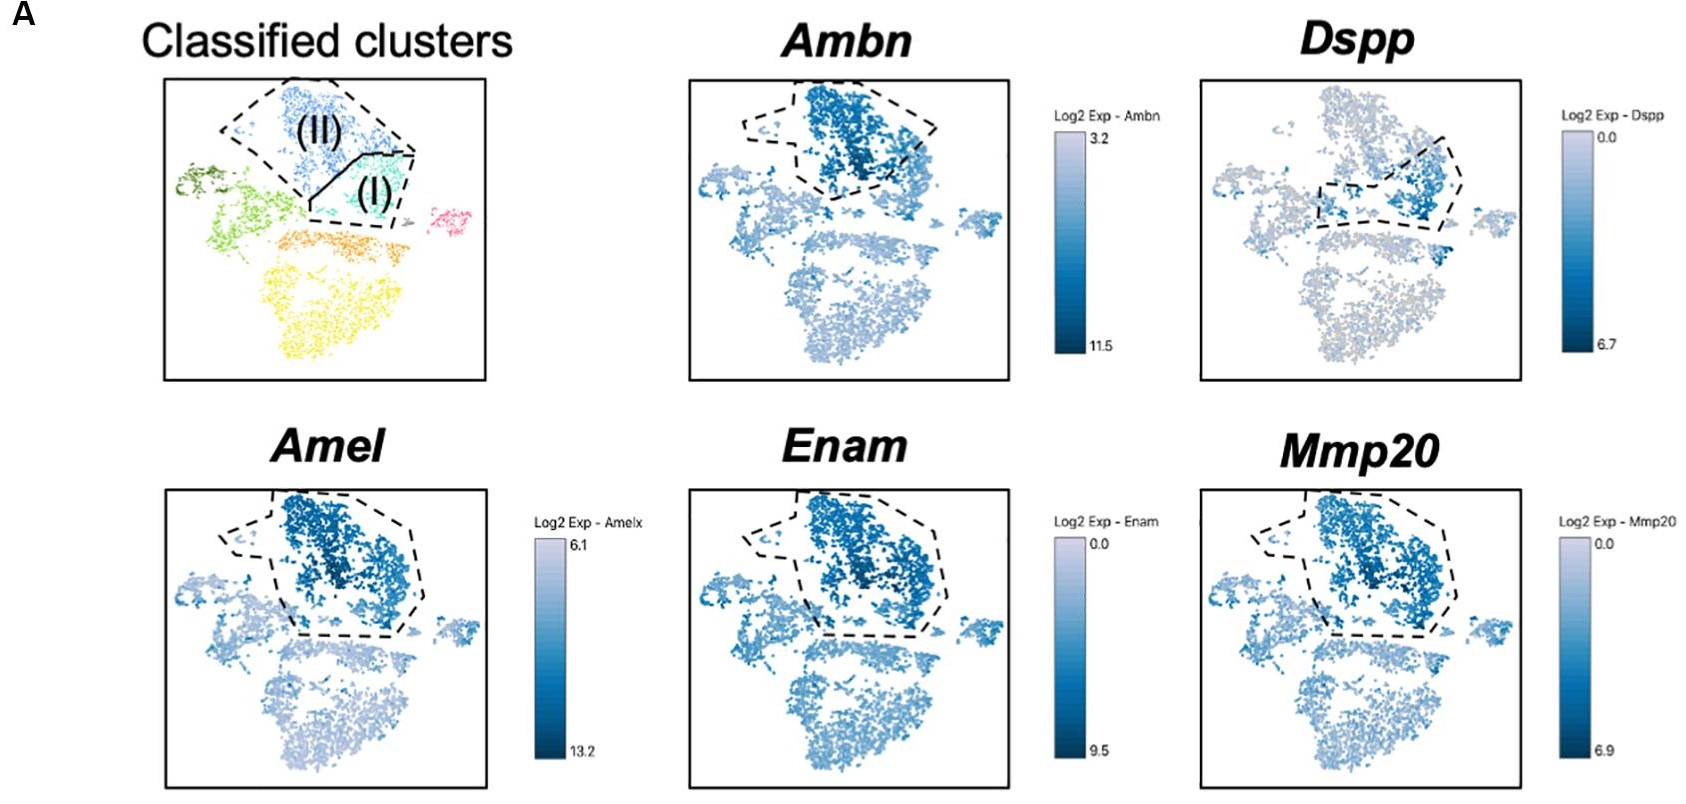